# Photo stitching
### Jan Eljasiak

In [8]:
# Importing required libraries
import cv2 as cv  # OpenCV for image processing
import numpy as np  # Numpy for numerical operations
from matplotlib import pyplot as plt  # Matplotlib for visualization

# Verify OpenCV version
print(cv.__version__)  # Print the OpenCV version to ensure compatibility

4.10.0


## Loading Images
Providing two images of Lake Como (taken by lovely girlfriend) for stitching

In [9]:
# Loading the images in grayscale mode
im1 = cv.imread('P1.jpg', cv.IMREAD_GRAYSCALE)
im2 = cv.imread('P2.jpg', cv.IMREAD_GRAYSCALE)

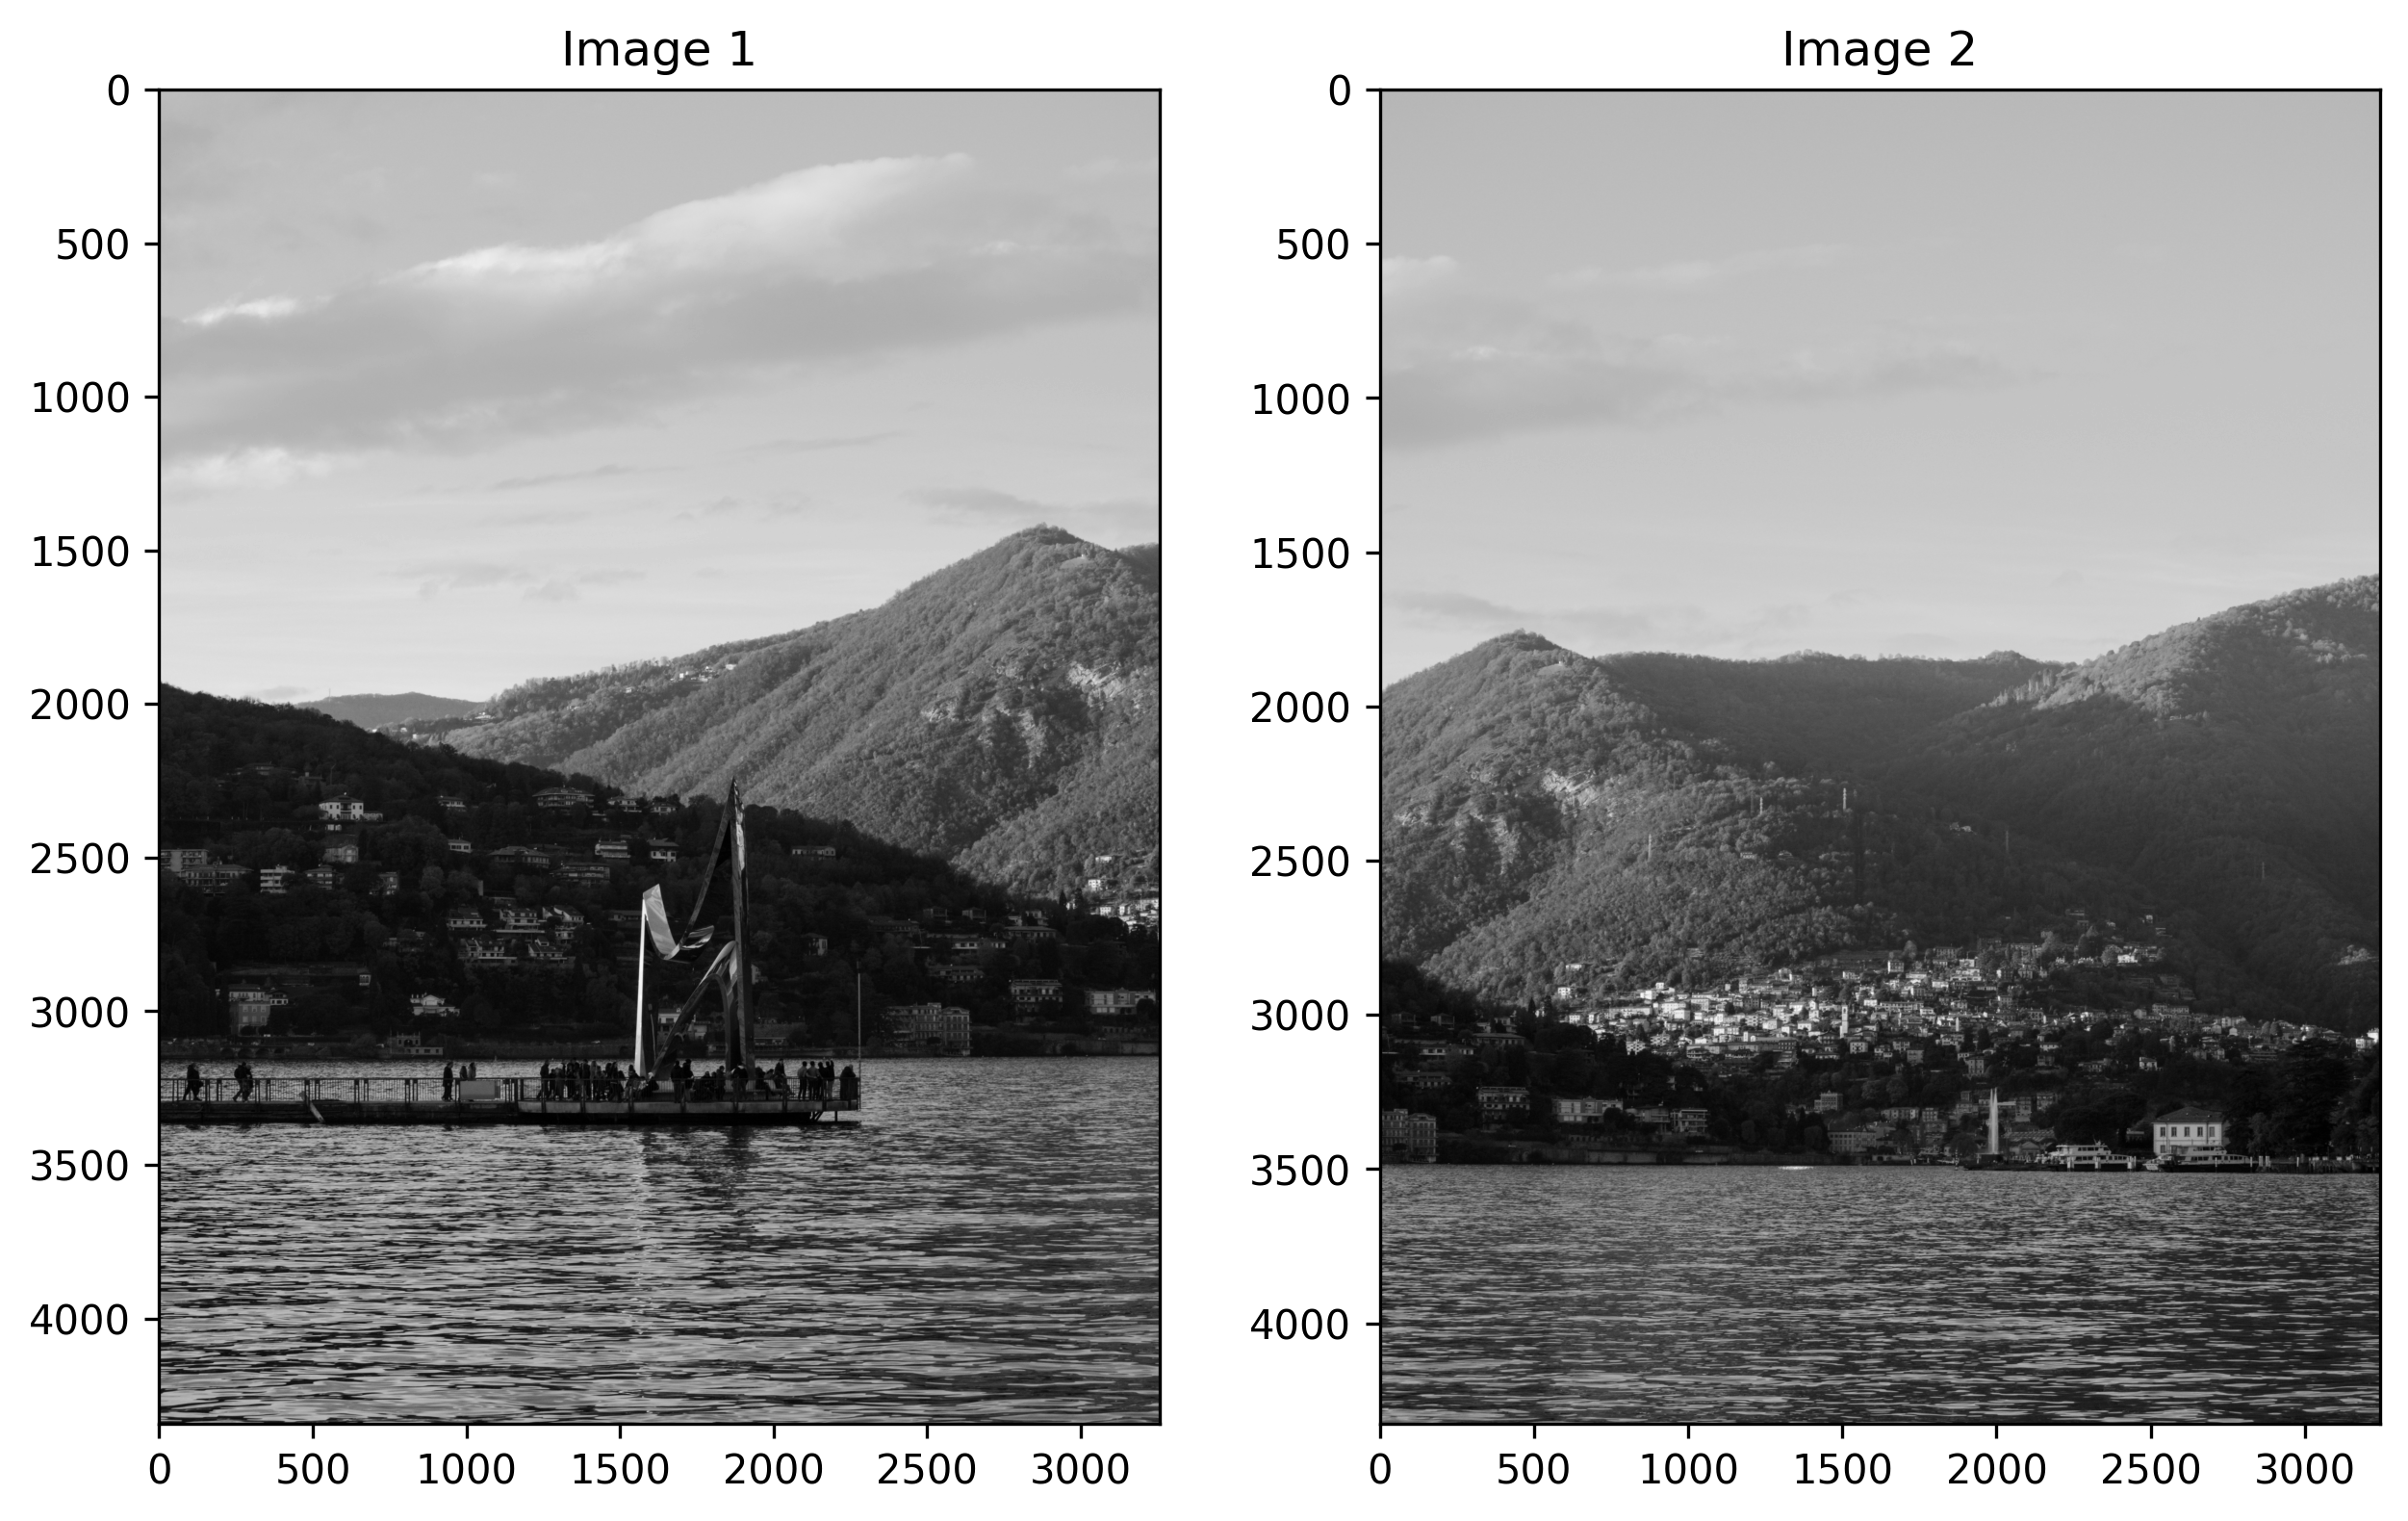

In [10]:
# Display the images side by side for visual reference
plt.figure(figsize=(10, 6), dpi=300)  # Set figure size for better visualization
plt.subplot(1, 2, 1)  # First subplot
plt.imshow(im1, cmap='gray')
plt.title("Image 1")
plt.subplot(1, 2, 2)  # Second subplot
plt.imshow(im2, cmap='gray')
plt.title("Image 2")
plt.show()

## Inspecting Image Dimensions
Investigate the shapes of the two images to ensure compatibility for stitching

In [11]:
print("Image 1 shape:", im1.shape)
print("Image 2 shape:", im2.shape)

Image 1 shape: (4343, 3257)
Image 2 shape: (4326, 3244)


## Adjusting Image Dimensions
Ensure both images have the same dimensions by cropping the larger one

In [12]:
# Crop Image 1 to match the dimensions of Image 2
im1 = im1[:im2.shape[0], :im2.shape[1]]
print("Adjusted Image 1 shape:", im1.shape)

Adjusted Image 1 shape: (4326, 3244)


## Keypoint Detection and Feature Extraction

In [13]:
# Create an instance for the Scale-Invariant Feature Transform (SIFT)
sift = cv.SIFT_create()

# Use the Scale-Invariant Feature Transform (SIFT)
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)

# Use Brute-Force Matcher with cross-checking to find matches between features
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

# Print the number of matches found
print("Number of matches:", len(matches))

Number of matches: 9006


Found over 9000 thousands matches using SIFT. Select the first 1000 matches with the shortest distances.

In [14]:
# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)
top_matches = matches[:1000]

## Visualizing Matches

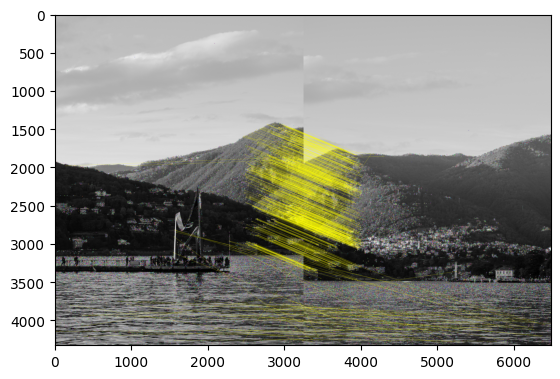

In [15]:
# Display the top matches between the two images
result = cv.drawMatches(im1, kps1, im2, kps2, top_matches, None, matchColor=[255, 255, 0])
plt.imshow(result)
plt.show()

## Compute Homography

In [16]:
# Find the homography which describes the transformation from the second set of points to the first one
def myHomography(kps1, kps2, matches):
    """
   Compute the homography matrix using corresponding points from matches.
   Args:
       kps1: Keypoints from the first image.
       kps2: Keypoints from the second image.
       matches: Matches between features of the two images.
   Returns:
       Homography matrix (H) for alignment.
   """

    # Extract corresponding points
    src_points = np.array([kps1[match.queryIdx].pt for match in matches])
    dst_points = np.array([kps2[match.trainIdx].pt for match in matches])

    # Compute homography matrix using RANSAC for robustness
    H = cv.findHomography(dst_points, src_points, method=cv.RANSAC)[0]
    return H


H = myHomography(kps1, kps2, matches)

## Warp the second image to align with the first image

In [17]:
# Function to warp an image using a homography matrix
def myWarp(image, H):
    """
    Warp an image using a homography matrix.
    Args:
        image: Image to be warped.
        H: Homography matrix.
    Returns:
        Warped image.
    """

    # Get the dimensions of the image
    cols, rows = image.shape

    # Warp the image using the homography matrix. The width of the output image is set to 2 * rows to provide enough space for both images to fit side by side after alignment
    return cv.warpPerspective(image, H, (2 * rows, cols))

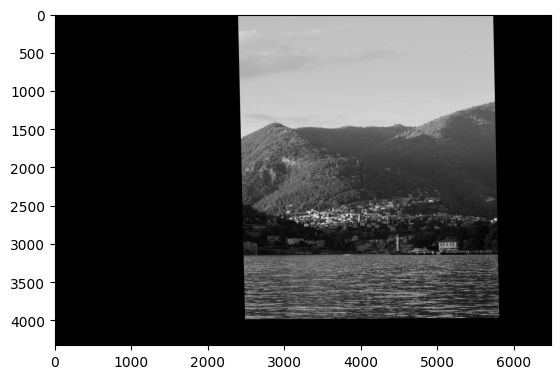

In [18]:
# Apply the warp to the second image
warped_image = myWarp(im2, H)

# Display the output
plt.imshow(warped_image, cmap='gray')
plt.show()

## Integrate the first image

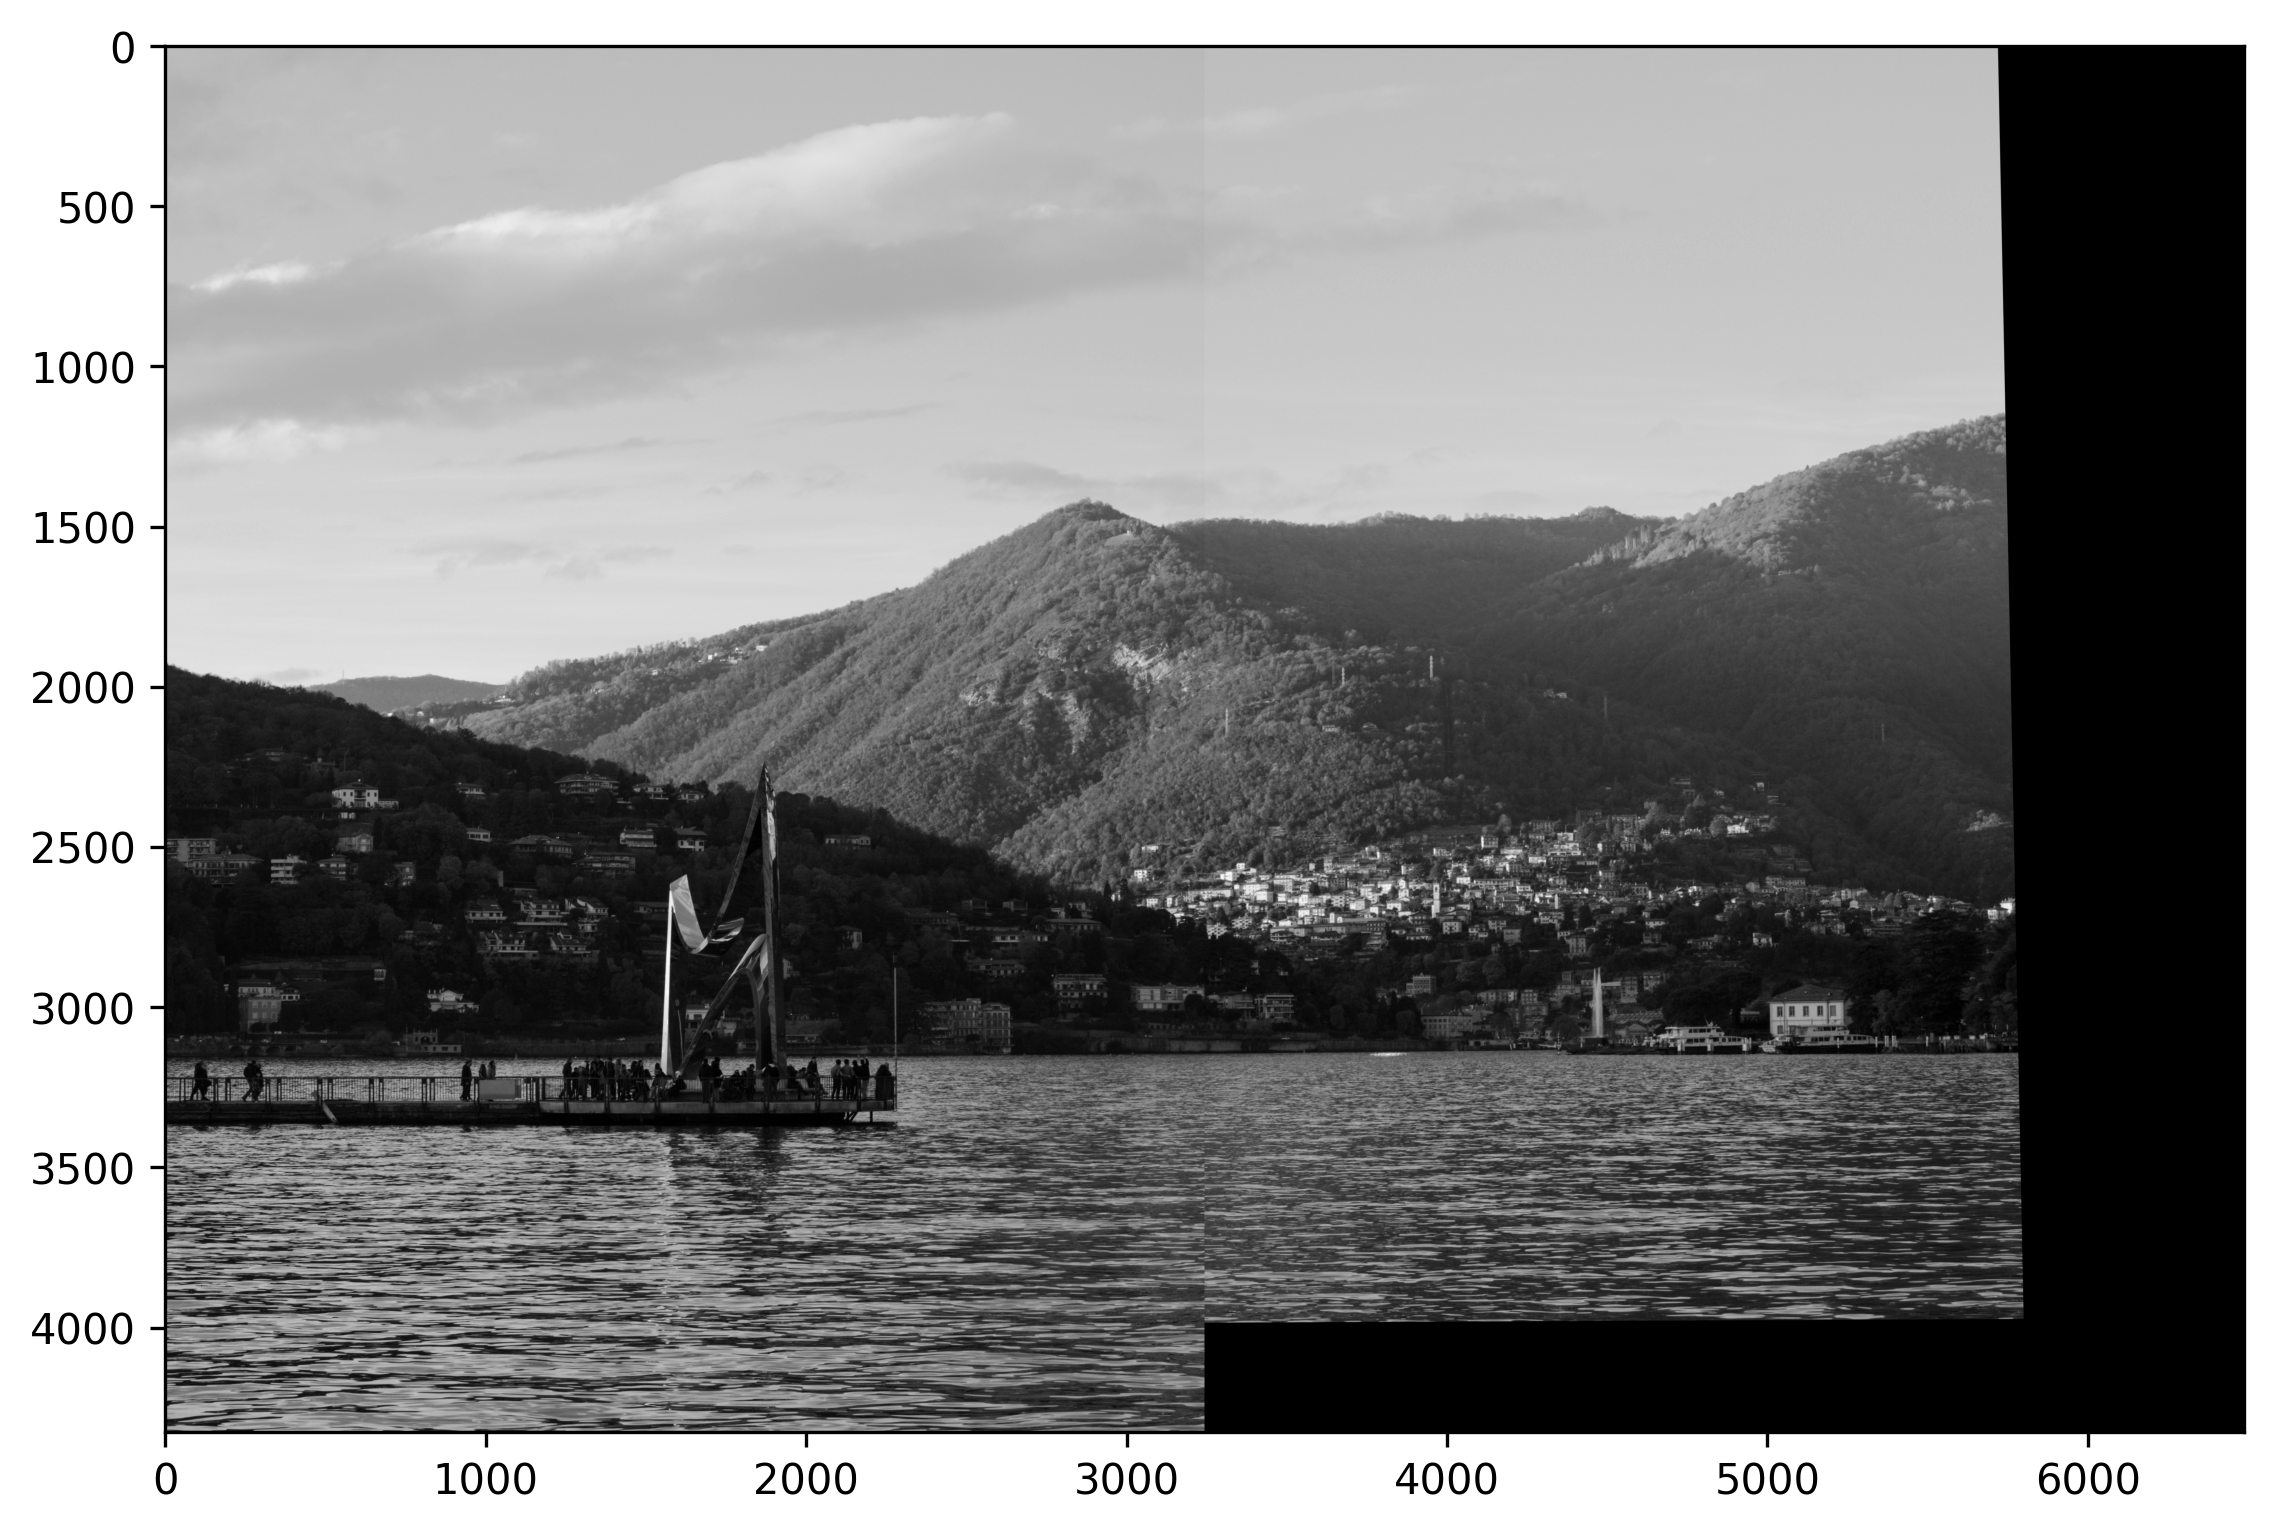

In [19]:
def myCollage(im_base, im_new):
    """
    Combine the base image (im_base) with the new image (im_new) to create a collage.
    Args:
        im_base: The base image where the new image will be placed.
        im_new: The new image to be stitched onto the base image.
    Returns:
        collaged_image: The resulting image after stitching.
    """

    # Define the size of the new image
    new_height, new_width = im_new.shape

    # Insert the new image into the base image at the defined location
    collaged_image = im_base.copy()  # Make a copy of the base image to avoid modifying it directly
    collaged_image[:new_height, :new_width] = im_new  # Paste the new image on top of the base image

    return collaged_image


# Apply the collage function to the warped image and the first image
result = myCollage(warped_image, im1)

# Display the final stitched image
plt.figure(figsize=(10, 6), dpi=300)  # Set figure size and resolution
plt.imshow(result, cmap="gray")
plt.show()